In [ ]:
import pickle 
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from sklearn.preprocessing import RobustScaler,StandardScaler, MinMaxScaler,QuantileTransformer
import pickle
from scipy.stats import skew,kurtosis,iqr
# from ecg import ecg_feature_computation
import math
# from hrvanalysis import remove_ectopic_beats
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from pprint import pprint
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score,auc,classification_report,make_scorer,roc_curve
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV
from sklearn import preprocessing,metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from joblib import Parallel,delayed
delta = 0.1
from sklearn.metrics import roc_curve,auc,make_scorer
from copy import deepcopy

def my_score_auc(y_true,y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    return auc(fpr,tpr)

def f1Bias_scorer_CV(y_true,y_pred, ret_bias=False):
    probs = y_true
    y = y_pred
    if not ret_bias:
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        return auc(fpr,tpr)
    precision, recall, thresholds = metrics.precision_recall_curve(y, probs)
    
    f1 = 0.0
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0) and (precision[i]>=recall[i]-.05):
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1


def fit_model(X,y,groups,k,paramGrid):
    my_score = make_scorer(my_score_auc,needs_threshold=True)
    X = np.delete(X,k,axis=1)
    clf = Pipeline([('svc', SVC())])
    gkf = GroupKFold(n_splits=len(np.unique(groups)))
    grid_search = GridSearchCV(clf, paramGrid, n_jobs=10,cv=list(gkf.split(X,y,groups=groups)),
                               scoring='f1',verbose=1)
    grid_search.fit(X,y)
    clf = grid_search.best_estimator_
    clf.set_params(svc__probability=True)
    probs = cross_val_predict(clf,X,y,cv=gkf.split(X,y,groups=groups),n_jobs=20,method='predict_proba')[:,1]
    pp = deepcopy(probs)
    a,b = f1Bias_scorer_CV(probs, y, ret_bias=True)
    return np.array([a,k]).reshape(-1)


def get_results_backward_elimination(X,y,groups):
    my_score = make_scorer(my_score_auc,needs_threshold=True)
    delta = 0.1
    paramGrid = {'svc__kernel': ['rbf'],
             'svc__C': [1,10,100],
             'svc__gamma': [np.power(2,np.float(x)) for x in np.arange(-8, -2, .25)],
             'svc__class_weight': [{0: w, 1: 1 - w} for w in [.2,.3,.4,.5]],
             'svc__probability':[False]
    }
    feature_names = ['var','iqr','mean','median','80th','20th','heartrate','vlf','lf','hf','lf-hf']
#     gg = fit_model(deepcopy(X),y,groups,k,paramGrid)
    data = []
    clf = Pipeline([('svc', SVC())])
    gkf = GroupKFold(n_splits=len(np.unique(groups)))
    grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=list(gkf.split(X,y,groups=groups)),
                               scoring='f1',verbose=1)
    grid_search.fit(X,y)
    clf = grid_search.best_estimator_
    clf.set_params(svc__probability=True)
    probs = cross_val_predict(clf,X,y,cv=gkf.split(X,y,groups=groups),n_jobs=20,method='predict_proba')[:,1]
    pp = deepcopy(probs)
    a,b = f1Bias_scorer_CV(probs, y, ret_bias=True)
    data.append(['all',a])
    print(data)
    while len(feature_names)>1:
        results = Parallel(n_jobs=30,verbose=4)(delayed(fit_model)(deepcopy(X),y,groups,k,paramGrid) for k,name in enumerate(feature_names))
        results = np.array(results)
        print(results,results.shape)
        ind_min = np.argmax(results[:,0])
        min_f1 = results[ind_min,0]
        min_index = np.int64(results[ind_min,1])
        name_feature = feature_names[min_index]
        data.append([name_feature,min_f1])
        X = np.delete(X,min_index,axis=1)
        feature_names = feature_names[:min_index] + feature_names[(min_index+1):]
        print(data)
    print(data)
    return data    
    
    

def get_f1(X,y,groups):
    my_score = make_scorer(my_score_auc,needs_threshold=True)
    paramGrid = {
#             'svc__min_samples_leaf': [4],
#             'svc__max_features': [.7,1],
#             'svc__n_estimators': [100,200,300],
#             'svc__criterion':['gini','entropy'],
             'svc__kernel': ['rbf'],
             'svc__C': [1,10,100],
             'svc__gamma': [np.power(2,np.float(x)) for x in np.arange(-8, -2, .5)],
             'svc__class_weight': [{0: w, 1: 1 - w} for w in [.2,.3,.4,.5]],
             'svc__probability':[False]
            }
#     paramGrid = {
#             'svc__min_samples_leaf': [4],
#             'svc__max_features': [.7,1],
#             'svc__n_estimators': [100,200,300],
#             'svc__criterion':['gini','entropy'],
# #              'svc__kernel': ['rbf'],
# #              'svc__C': [1],
# # #              'svc__gamma': [np.power(2,np.float(x)) for x in np.arange(-8, -2, .25)],
# #              'svc__class_weight': [{0: w, 1: 1 - w} for w in [.2,.3,.4,.5]],
# #              'svc__probability':[False]
#             }
    my_score = make_scorer(f1Bias_scorer_CV,needs_proba=True)
    clf = Pipeline([('svc',SVC())])
    gkf = GroupKFold(n_splits=len(np.unique(groups)))
    grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=list(gkf.split(X,y,groups=groups)),
                               scoring='f1',verbose=2)
    grid_search.fit(X[:,:],y)
    clf = grid_search.best_estimator_
    clf.set_params(svc__probability=True)
    probs = cross_val_predict(clf,X,y,cv=gkf.split(X,y,groups=groups),n_jobs=20,method='predict_proba')[:,1]
    f1,bias = f1Bias_scorer_CV(probs, y, ret_bias=True)
    print(f1,bias,'bias')
    y_pred = probs
    y_pred[y_pred>=bias] = 1
    y_pred[y_pred<bias] = 0
    y_pred = np.int64(y_pred)
    clf.fit(X,y)
    return confusion_matrix(y,y_pred),f1_score(y,y_pred),precision_score(y,y_pred),recall_score(y,y_pred),clf,y,y_pred
    
def get_label(user_data,st,et):
    label = 2
    for k in range(user_data.shape[0]):
        if st>=user_data[k,0] and et<=user_data[k,1]:
            label = user_data[k,2]

    return label

def get_quality_features(a):
    feature = [np.mean(a),np.percentile(a,50),np.min(a)]
    return np.array(feature)

import numpy as np
from scipy import interpolate, signal
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import matplotlib.patches as mpatches
from collections import OrderedDict

def frequencyDomain(RRints,tmStamps, band_type = None, lf_bw = 0.11, hf_bw = 0.1, plot = 0):
    NNs = RRints
    tss = tmStamps
    frequency_range = np.linspace(0.001, 1, 10000)
    NNs = np.array(NNs)
    NNs = NNs - np.mean(NNs)
    result = signal.lombscargle(tss, NNs, frequency_range)
        
    #Pwelch w/ zero pad     
    fxx = frequency_range 
    pxx = result 
    
    vlf= (0.003, 0.04)
    lf = (0.04, 0.15)
    hf = (0.15, 0.4)
    
    plot_labels = ['VLF', 'LF', 'HF']
        
    if band_type == 'adapted':     
            
        vlf_peak = fxx[np.where(pxx == np.max(pxx[np.logical_and(fxx >= vlf[0], fxx < vlf[1])]))[0][0]] 
        lf_peak = fxx[np.where(pxx == np.max(pxx[np.logical_and(fxx >= lf[0], fxx < lf[1])]))[0][0]]
        hf_peak = fxx[np.where(pxx == np.max(pxx[np.logical_and(fxx >= hf[0], fxx < hf[1])]))[0][0]]
    
        peak_freqs =  (vlf_peak, lf_peak, hf_peak) 
            
        hf = (peak_freqs[2] - hf_bw/2, peak_freqs[2] + hf_bw/2)
        lf = (peak_freqs[1] - lf_bw/2, peak_freqs[1] + lf_bw/2)   
        vlf = (0.003, lf[0])
        
        if lf[0] < 0:
            print('***Warning***: Adapted LF band lower bound spills into negative frequency range')
            print('Lower thresold of LF band has been set to zero')
            print('Adjust LF and HF bandwidths accordingly')
            lf = (0, lf[1])        
            vlf = (0, 0)
        elif hf[0] < 0:
            print('***Warning***: Adapted HF band lower bound spills into negative frequency range')
            print('Lower thresold of HF band has been set to zero')
            print('Adjust LF and HF bandwidths accordingly')
            hf = (0, hf[1])        
            lf = (0, 0)        
            vlf = (0, 0)
            
        plot_labels = ['Adapted_VLF', 'Adapted_LF', 'Adapted_HF']

    df = fxx[1] - fxx[0]
    vlf_power = np.trapz(pxx[np.logical_and(fxx >= vlf[0], fxx < vlf[1])], dx = df)      
    lf_power = np.trapz(pxx[np.logical_and(fxx >= lf[0], fxx < lf[1])], dx = df)            
    hf_power = np.trapz(pxx[np.logical_and(fxx >= hf[0], fxx < hf[1])], dx = df)             
    totalPower = vlf_power + lf_power + hf_power
    
    #Normalize and take log
    vlf_NU_log = np.log((vlf_power / (totalPower - vlf_power)) + 1)
    lf_NU_log = np.log((lf_power / (totalPower - vlf_power)) + 1)
    hf_NU_log = np.log((hf_power / (totalPower - vlf_power)) + 1)
    lfhfRation_log = np.log((lf_power / hf_power) + 1)   
    
    freqDomainFeats = {'VLF_Power': vlf_NU_log, 'LF_Power': lf_NU_log,
                       'HF_Power': hf_NU_log, 'LF/HF': lfhfRation_log}
    return freqDomainFeats


def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return average, math.sqrt(variance)

def get_weighted_rr_features(a):
    a = np.repeat(a[:,0],np.int64(np.round(100*a[:,1])))
#     a = a[:,0]
    return np.array([np.var(a),iqr(a),np.mean(a),np.median(a),np.percentile(a,80),np.percentile(a,20),60000/np.median(a)])


def get_ms(ecg_rr):
    mean_col = []
    std_col = []
    i = 0
    while i < len(ecg_rr):
        start_ts = ecg_rr[i,0]
        j = i
        while j<len(ecg_rr) and ecg_rr[j,0]-start_ts <= 60000:
            j+=1
        mean_col.append(np.mean(ecg_rr[i:j+1,1]))
        std_col.append(np.std(ecg_rr[i:j+1,1]))
        i=j
    m = np.percentile(mean_col,70)
    s = np.percentile(std_col,30)
    return m,s


def remove_3sd(rr_ppg_int):
    ts_array = np.arange(rr_ppg_int[0,0],rr_ppg_int[-1,0],1000)
    rr_interval = np.zeros((0,3))
    for t in ts_array:
        index = np.where((rr_ppg_int[:,0]>=t-4000)&(rr_ppg_int[:,0]<=t+4000))[0]
        if len(index) < 1:
            continue
        if np.sum(rr_ppg_int[index,2])==0:
            continue
        mw,sw = weighted_avg_and_std(rr_ppg_int[index,1],rr_ppg_int[index,2])
        rr_interval = np.concatenate((rr_interval,np.array([t,mw,np.mean(rr_ppg_int[index,2])]).reshape(-1,3)))
    if len(rr_interval)<30:
        return []
    rr_ppg_int = rr_interval
    return rr_ppg_int

no_of_feature = 11
from scipy.stats import variation
def combine_data_sobc(feature_matrix,user_col,label_col,quality_col,heart_rate_final,label_data,qual=0):
    if len(user_col)==0:
        return np.zeros((0,no_of_feature)),[],[],[],[],np.zeros((0,4))
    participant = user_col[0]
    feature_matrix = []
    feature_matrix_quality = []
    user_col = []
    label_col = []
    quality_col = []
    if len(heart_rate_final)<80:
        return np.zeros((0,no_of_feature)),[],[],[],[],np.zeros((0,4))
    if len(heart_rate_final)<80:
        return np.zeros((0,no_of_feature)),[],[],[],[],np.zeros((0,4))
    ts_array = np.arange(heart_rate_final[0,0],heart_rate_final[-1,0],60000)
    for t in ts_array:
        index = np.where((heart_rate_final[:,0]>=t-30000)&(heart_rate_final[:,0]<t+30000))[0]
        if len(index)<30:
            continue
        heart_rate_window = heart_rate_final[index]
        label = get_label(label_data,t-30000,t+30000)
        if len(heart_rate_window)<30:
            continue
        feature = get_weighted_rr_features(heart_rate_window[:,1:])
        feature_freq = frequencyDomain(heart_rate_window[:,1]/1000,heart_rate_window[:,0]/1000)
        feature = list(feature)+list(feature_freq.values())
        feature_quality = get_quality_features(heart_rate_window[:,2])
        if feature_quality[0]<qual:
            continue
        feature_matrix.append(np.array(feature).reshape(-1,no_of_feature))
        feature_matrix_quality.append(np.array(feature_quality).reshape(-1,3))
        user_col.append(participant)
        label_col.append(label)
        quality_col.append(np.mean(heart_rate_window[:,2]))
    return np.array(feature_matrix).reshape(-1,no_of_feature),user_col,label_col,quality_col,heart_rate_final,np.array(feature_matrix_quality).reshape(-1,3)

from sklearn import linear_model
def get_only_stress_no_stress(X,groups,y,X_qual):
    y = np.int64(y)
    index = np.where(y<2)[0]
    X,groups,y,X_qual = X[index,:],groups[index],y[index],X_qual[index]
    ind = []
    for grp in np.unique(groups):
        tmp = np.where(groups==grp)[0]
        if len(np.unique(y[tmp]))>1 and np.sum(y[tmp])/len(y[tmp])>=.1 and len(y[tmp])>20:
            ind.extend(list(tmp))
    ind = np.int64(np.array(ind))
    return X[ind],y[ind],groups[ind],X_qual[ind]

def get_XY(window,qual1=0):
    final_data = pickle.load(open('/home/jupyter/mullah/Test/data_yield/data/data_sobc_'+str(window)+'_secs.v1.p','rb'))
    duration = window
#     final_output = [combine_data_sobc(*(a+[qual1])) for a in final_data]
    final_output = Parallel(n_jobs=30,verbose=1)(delayed(combine_data_sobc)(*(a[:-1]+[qual1])) for i,a in enumerate(final_data) if i%2==1)
    X = np.zeros((0,no_of_feature))
    X_qual = []
    y = []
    groups = []
#     qual = []
    for m in final_output:
        feature_matrix,user_col,label_col,quality_col,hr,quals = m
        if len(feature_matrix)<10:
            continue
        quals1 = np.array([1]*feature_matrix.shape[0])
#         quals1 = np.sqrt(np.sum(np.square(quals),axis=1)/quals.shape[1])
        ss = np.repeat(feature_matrix[:,2],np.int64(np.round(100*quals1)))
        rr_70th = np.percentile(ss,20)
        rr_95th = np.percentile(ss,95)
        index = np.where((feature_matrix[:,2]>rr_70th)&(feature_matrix[:,2]<rr_95th))[0]
        for i in range(feature_matrix.shape[1]):
            m,s = weighted_avg_and_std(feature_matrix[index,i], quals1[index])
            feature_matrix[:,i]  = (feature_matrix[:,i] - m)/s
        tmp = StandardScaler().fit_transform(np.nan_to_num(feature_matrix))
        X = np.concatenate((X,feature_matrix))
#         print(X.shape)
        X_qual.extend(quals.reshape(1,-2,3))
        y.extend(label_col)
        groups.extend(user_col)
#         qual.extend(quality_col)
#     X[X<-4] = -4
#     X[X>4] = 4
    print(X.shape)
    y = np.array(y)
    groups = np.array(groups)
    X_qual = np.concatenate(X_qual)
    print(X_qual.shape)
    y = y[~np.isnan(X).any(axis=1)]
    groups = groups[~np.isnan(X).any(axis=1)]
    X_qual = X_qual[~np.isnan(X).any(axis=1)]
    X = X[~np.isnan(X).any(axis=1)]
#     y = y[~np.isinf(X).any(axis=1)]
#     qual = np.array(qual)
#     qual = qual[~np.isinf(X).any(axis=1)]
#     groups = groups[~np.isinf(X).any(axis=1)]
#     X = X[~np.isinf(X).any(axis=1)]
#     X_qual = X_qual[~np.isinf(X).any(axis=1)]
    X,y,groups,X_qual = get_only_stress_no_stress(X,groups,y,X_qual)
    print(X.shape,y.shape,len(np.unique(groups)),X_qual.shape)
    return X,y,groups,X_qual
#     pickle.dump([X,y,groups,X_qual],open('lab_data.p','wb'))
#     index = np.array([0,1,3,4,5,6,8])
#     print(qual1,X.shape,X_qual.shape,len(y),len(y[y==1]),len(groups),len(np.unique(groups)))
#     data  = get_results_backward_elimination(X[:,:],y,groups)
#     print(data)
#     m,f,p,r,clf,y,y_pred = get_f1(X[:,index],y,groups)    
#     print(np.array([duration,m,f,p,r]))
#     return np.array([qual1,duration,m,f,p,r,len(np.unique(groups)),X.shape[0]]),clf
#     return [qual,data]
# for window in np.arange(2,16,1):
# results = Parallel(n_jobs=30,verbose=4)(delayed(get_XY)(window) for window in np.arange(2,16,1)[:1])

# x_act,y_act,x_like,y_like = pickle.load(open('../code_stress/thresholds.p','rb'))
# thresholds = np.zeros((len(x_like),3))
# thresholds[:,0] = x_like
# thresholds[:,1] = y_like
# likelihoods = np.array(list(zip(x_act,y_act)))
# for i in range(thresholds.shape[0]):
#     yield_ = thresholds[i,1]
#     index = np.abs(likelihoods[:,1]-yield_).argmin()
#     activity_threshold = likelihoods[index,0]
#     thresholds[i,2] = activity_threshold
# results = [get_XY(window=5,qual1=q) for q in [0]]
results = []
for q in [.2]:
    X,y,groups,X_qual = get_XY(window=5,qual1=q)
    feature_index = np.array([0,1,3,4,5,6,8])
#     index = np.where(X_qual[:,0]>=q)[0]
    m,f,p,r,clf,y,y_pred = get_f1(X[:,feature_index],y,groups)
    print(q,m,f,p,r)
    results.append([m,f,p,r,clf])

In [ ]:
import pickle
pickle.dump(clf,open('/home/jupyter/mullah/cc3/stress_model_quality_integrated_reduced_features_mean_threshold_0.p','wb'))

In [ ]:
import numpy as np
keys = np.arange(0,.5,.05)
quality_integrated_f1 = [.66,.66,.67,.68,.70,.71,.71,.73,.74,.73]
not_quality_integrated_f1 = [.64,.64,.65,.66,.66,.67,.67,.70,.69,.70]
yields = [606,587,517,445,384,333,283,235,190,157]
len(keys),len(quality_integrated_f1),len(not_quality_integrated_f1)
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size':35})
# plt.figure(figsize=(30,15))
fig, ax = plt.subplots(figsize=(20,15))
ax.plot(yields,quality_integrated_f1,'*g',linewidth=4,markersize=25,label='Using Quality Integration')
ax.plot(yields,not_quality_integrated_f1,'or',linewidth=4,markersize=25,label='No Quality Integration')
for i,y in enumerate(yields):
    a = quality_integrated_f1[i]
    b = not_quality_integrated_f1[i]
    ax.vlines(y,a,b,linestyle='-.')
    if i!=9:
        ax.annotate(str(r'$\geq$')+"{:.2f}".format(keys[i]), (y+4, (a+b-.012)/2),color='brown',rotation=90)
    else:
        ax.annotate("$q_{mean}$"+str(r'$\geq$')+"{:.2f}".format(keys[i]), (y+4, (a+b-.021)/2),color='brown',rotation=90,label='Threshold on Mean Signal Quality')
        
ax.set_xlabel('Yield of Data in Field\n (Minutes per participant-wrist day)')
ax.set_ylabel('Stress Model Performance in Lab \n(Leave one subject F1 score)')

# plt.ylim([.64,.75])
ax.legend()
plt.savefig('quality_screening.pdf',bbox_inches='tight')
plt.show()

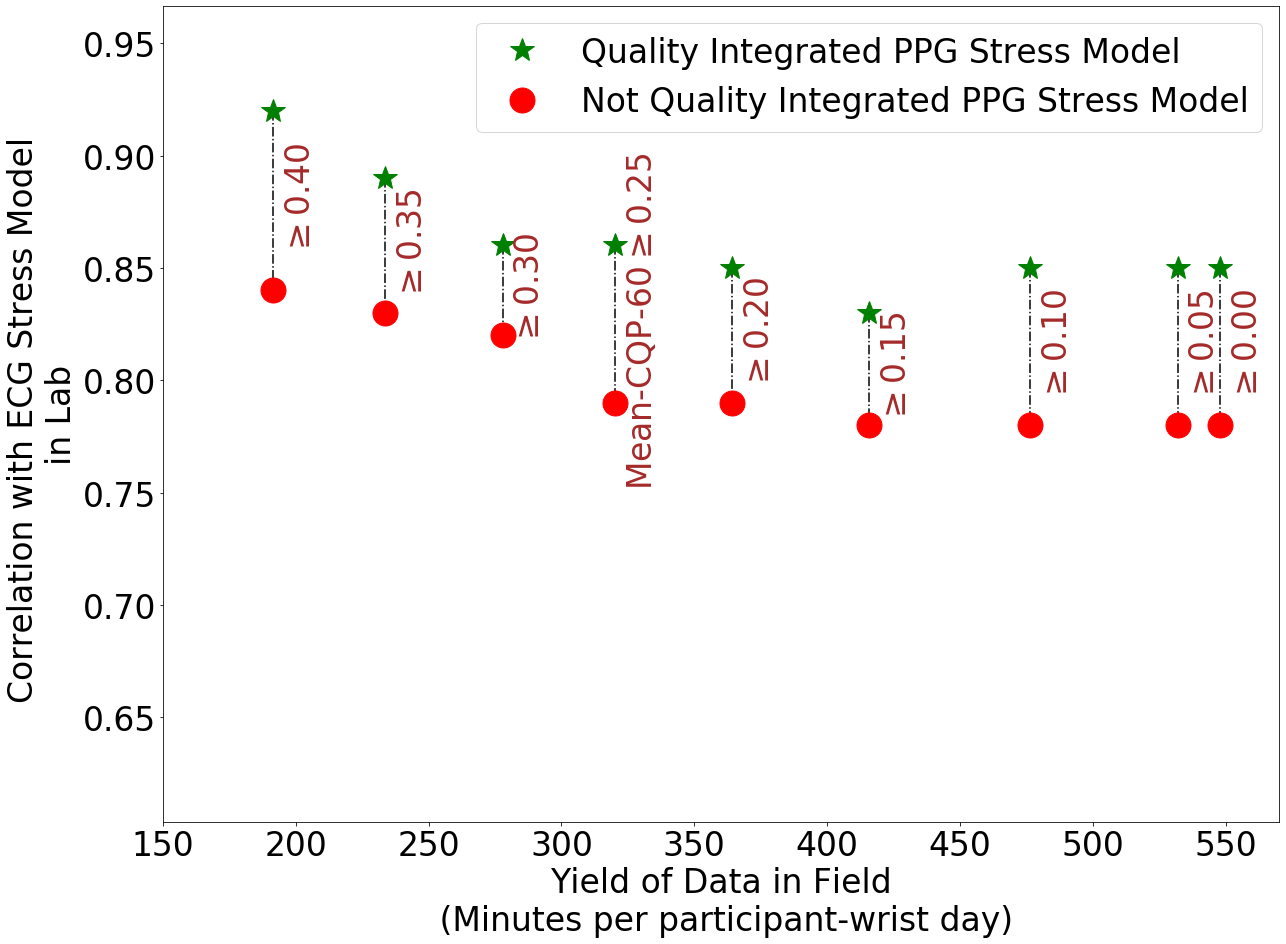

In [88]:
import numpy as np
keys = np.arange(0,.45,.05)
quality_integrated_f1 = [0.44,0.46,0.5,0.56,0.62,0.68,0.7,0.74,0.77,0.78,0.79,0.79]
not_quality_integrated_f1 = [0.38,	0.4,	0.44,	0.47,	0.53,	0.59,	0.59,	0.63,	0.64,	0.67,	0.68,			0.69]
quality_integrated_f1 = [0.85,0.85,0.85,0.83,0.85,0.86,0.86,0.89,0.92]
not_quality_integrated_f1 = [0.78,0.78,0.78,0.78,0.79,0.79,0.82,0.83,0.84]
yields = [547.8,531.96,476.3,415.79,364.28,320.28,277.9,233.54,191.41,160,144.35,113.69][:len(keys)]
len(keys),len(quality_integrated_f1),len(not_quality_integrated_f1)
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size':33})
# plt.figure(figsize=(30,15))
fig, ax = plt.subplots(figsize=(20,15))
ax.plot(yields,quality_integrated_f1,'*g',linewidth=4,markersize=25,label='Quality Integrated PPG Stress Model')
ax.plot(yields,not_quality_integrated_f1,'or',linewidth=4,markersize=25,label='Not Quality Integrated PPG Stress Model')
for i,y in enumerate(yields):
    a = quality_integrated_f1[i]
    b = not_quality_integrated_f1[i]
    ax.vlines(y,a,b,linestyle='-.')
    if i!=5:
        ax.annotate(str(r'$\geq$')+"{:.2f}".format(keys[i]), (y+4, (a+b-.042)/2),color='brown',rotation=90)
    else:
        ax.annotate(str("Mean-CQP-60"+str(r'$\geq$')+"{:.2f}".format(keys[i])), (y+4, (a+b-.141)/2),color='brown',fontweight=500,
                    rotation=90,label='Threshold on Mean Signal Quality')
        

        
ax.set_xlabel('Yield of Data in Field\n (Minutes per participant-wrist day)')
ax.set_ylabel('Correlation with ECG Stress Model \nin Lab')
ax.plot([10],[.62])
ax.plot([10],[.95])

# ax.set_ylim([.62,.8])
plt.xlim([150,570])
ax.legend()
plt.savefig('quality_screening_concordance.pdf',bbox_inches='tight')
plt.show()

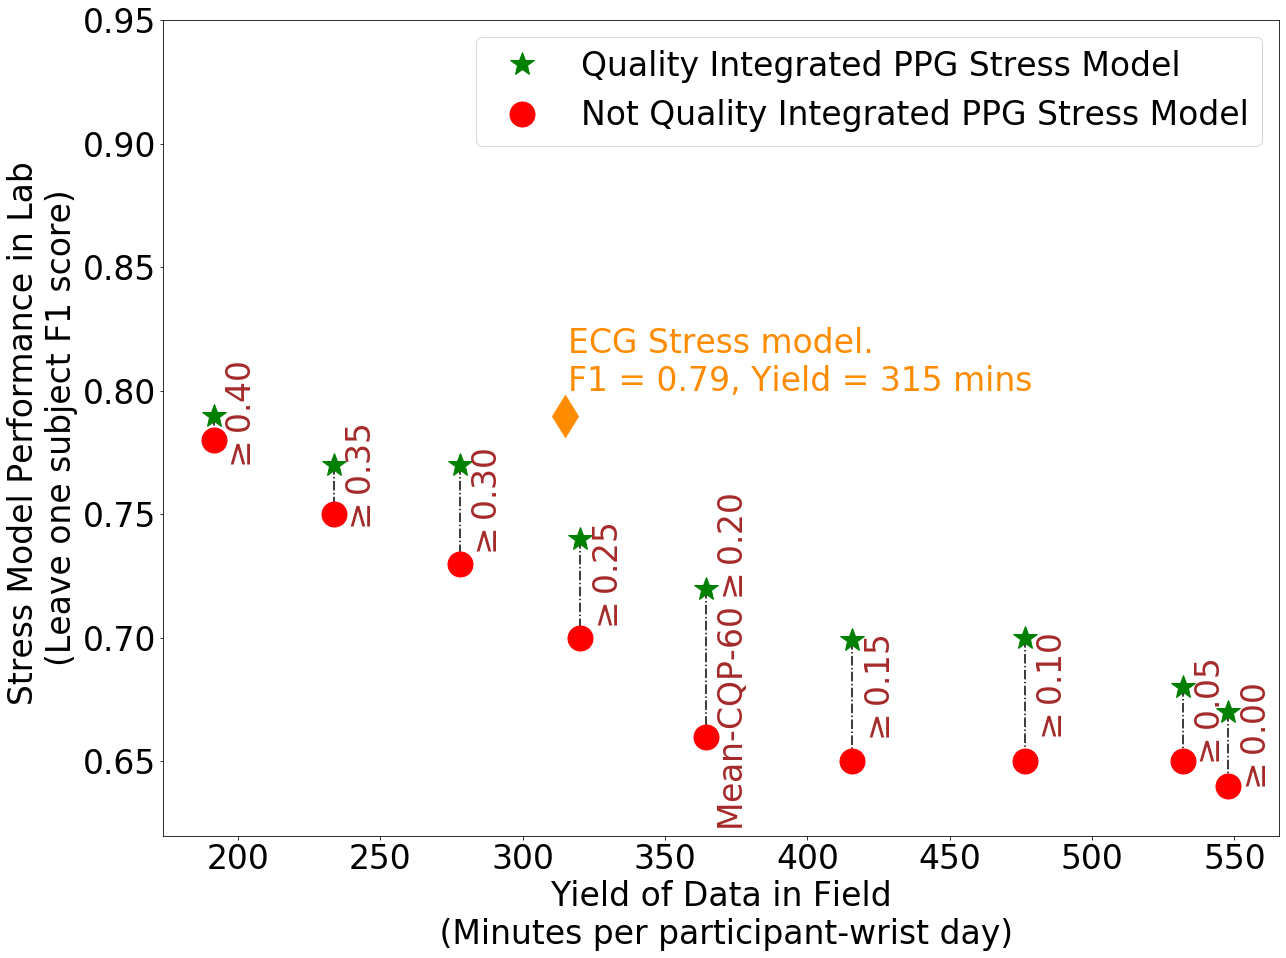

In [96]:
[.64,.65,.65,.65,.66,.70,.73,.75,.79,.81]
[.697,.697,.70,.699,.72,.73,.77,.77,.79,.81]

import numpy as np
keys = np.arange(0,.45,.05)
length = len(keys)
quality_integrated_f1 = [0.44,0.46,0.5,0.56,0.62,0.68,0.7,0.74,0.77,0.78,0.79,0.79][:length]
not_quality_integrated_f1 = [0.38,	0.4,	0.44,	0.47,	0.53,	0.59,	0.59,	0.63,	0.64,	0.67,	0.68,			0.69][:length]

quality_integrated_f1 = [.67,.68,.70,.699,.72,.74,.77,.77,.79,.81][:length]
not_quality_integrated_f1 = [.64,.65,.65,.65,.66,.70,.73,.75,.78,.81][:length]
yields = [547.8,531.96,476.3,415.79,364.28,320.28,277.9,233.54,191.41,160,144.35,113.69][:length]
len(keys),len(quality_integrated_f1),len(not_quality_integrated_f1)
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size':33})
# plt.figure(figsize=(30,15))
fig, ax = plt.subplots(figsize=(20,15))
ax.plot(yields,quality_integrated_f1,'*g',linewidth=4,markersize=25,label='Quality Integrated PPG Stress Model')
ax.plot(yields,not_quality_integrated_f1,'or',linewidth=4,markersize=25,label='Not Quality Integrated PPG Stress Model')
# ax.hlines(.79,150,570,linestyle='--',color='brown',linewidth=4)
# ax.vlines(315,.62,.85,linestyle='-.',color='orange',linewidth=4)
ax.plot([315],[.79],'d',markersize=30,color='darkorange')
ax.annotate('ECG Stress model.\nF1 = 0.79, Yield = 315 mins', (316, .80),color='darkorange',rotation=0)


# ax.annotate('ECG Stress Model, F1 = $0.79$', (315, .791),color='brown',rotation=0)
for i,y in enumerate(yields):
    a = quality_integrated_f1[i]
    b = not_quality_integrated_f1[i]
    ax.vlines(y,a,b,linestyle='-.')
    if i!=4:
        ax.annotate(str(r'$\geq$')+"{:.2f}".format(keys[i]), (y+4, (a+b-.032)/2),color='brown',rotation=90)
    else:
        ax.annotate(str("Mean-CQP-60"+str(r'$\geq$')+"{:.2f}".format(keys[i])), (y+4, (a+b-.131)/2),color='brown',fontweight=500,
                    rotation=90,label='Threshold on Mean Signal Quality')
        
ax.set_xlabel('Yield of Data in Field\n (Minutes per participant-wrist day)')
ax.set_ylabel('Stress Model Performance in Lab \n(Leave one subject F1 score)')
plt.ylim([.62,.95])
ax.legend()
plt.savefig('quality_screening.pdf',bbox_inches='tight')
plt.show()

In [ ]:
pickle.dump([thresholds[:,:],results],open('likelihood_threshold_lab_f12.p','wb'))

In [ ]:
pickle.dump(results,open('../data/stress_without_quality_without_normalization_new.p','wb'))

In [ ]:
results

In [ ]:
pickle.dump(results[0][1],open('../models/stress_ppg_final_no_quality_0_qual.p','wb'))

In [ ]:
data = pickle.load(open('../data/backward_elimination_with_quality_and_without_normalization_for_.2_threshold.p','rb'))

In [ ]:
want = pickle.load(open('../data/stress_with_quality_without_normalization7.p','rb'))
not_want = pickle.load(open('../data/stress_without_quality_without_normalization7.p','rb'))

In [ ]:
import seaborn as sns
conf = np.array([[2305,  299],
         [ 248,  568]])
plt.rcParams.update({"font.size":45})
plt.figure(figsize=(10,8))
sns.heatmap(conf,fmt='g',annot=True,cbar=False)
plt.xticks([0.5,1.5],['Not Stress','Stress'])
plt.yticks([0.5,1.5],['Not \nStress','Stress'],rotation=0)
plt.show()

In [ ]:
want = pickle.load(open('../data/stress_with_quality_without_normalization7.p','rb'))
not_want = pickle.load(open('../data/stress_without_quality_without_normalization7.p','rb'))
index = [0,3,4,5]
want =np.array([np.array(i[0])[index] for i in want])

not_want = np.array([np.array(i[0])[index] for i in not_want])

In [ ]:
# want,not_1ant
want = pickle.load(open('../data/stress_with_quality_without_normalization7.p','rb'))
not_want = pickle.load(open('../data/stress_without_quality_without_normalization7.p','rb'))
index = [0,3,4,5]
want =np.array([np.array(i[0])[index] for i in want])

not_want = np.array([np.array(i[0])[index] for i in not_want])
final = []
for i in range(11):
    final.append([want[i][0],want[i][1],'Quality Weighted Features'])
#     final.append([want[i][0],want[i][2],'Precision','Using Quality Weighted Features'])
#     final.append([want[i][0],want[i][3],'Recall','Using Quality Weighted Features'])

for i in range(11):
    final.append([not_want[i][0],not_want[i][1],'Original Features'])
#     final.append([not_want[i][0],not_want[i][2],'Precision','Using Quality Weighted Features'])
#     final.append([not_want[i][0],not_want[i][3],'Recall','Using Quality Weighted Features'])

df = pd.DataFrame(final,columns=['Quality Threshold','F1 Score','Type of Features'])
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams.update({"font.size":20})
import seaborn as sns
plt.figure(figsize=(12,8))
# sns.lineplot(x='Quality Threshold',y='F1 Score',hue='Type of Features',data=df, dashes=True)
plt.plot(want[:,0],want[:,1],'--',marker='o',linewidth=3,markersize=20,label='Using Quality Weighted Features')
plt.plot(not_want[:,0],not_want[:,1],'--',marker='s',linewidth=3,markersize=20,label='Using Normal Features')
plt.ylabel('F1 score')
plt.xlabel('Minimum Signal Quality')
plt.legend()
# plt.xticks(want[:,0],want[:,0])
plt.show()

In [ ]:
df = pd.DataFrame(final,columns=['Quality Threshold','F1 Score','Type of Features'])

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams.update({"font.size":20})
import seaborn as sns
plt.figure(figsize=(12,8))
# sns.lineplot(x='Quality Threshold',y='F1 Score',hue='Type of Features',data=df, dashes=True)
plt.plot(want[:,0],want[:,1],'--',marker='o',linewidth=3,markersize=20,label='Using Quality Weighted Features')
plt.plot(not_want[:,0],not_want[:,1],'--',marker='s',linewidth=3,markersize=20,label='Using Normal Features')
plt.ylabel('F1 score')
plt.xlabel('Minimum Signal Quality')
plt.legend()
# plt.xticks(want[:,0],want[:,0])
plt.show()

In [ ]:
# results[0][1]
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('default')
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size':35})
# plt.figure(figsize=(30,15))
# fig, ax = plt.subplots(figsize=(20,15))
feature_importances = np.array([['All features', 0.7104795737122557], 
                     ['Mean', 0.7176781002638521], 
                     ['Lf-Hf', 0.7166813768755516], 
                     ['Median', 0.7165775401069518], 
                     ['Vlf', 0.7184986595174263], 
                     ['Hf', 0.7225691347011596], 
                     ['20th', 0.717720391807658], 
                     ['Var', 0.7109170305676856], 
                     ['IQR', 0.6998254799301921], 
                     ['Lf', 0.6993865030674846], 
                     ['80th', 0.6678832116788321],
                    ['Heart Rate',.65]])
plt.figure(figsize=(20,15))
plt.plot(feature_importances[:6,0],[np.float(a) for a in feature_importances[:6,1]],'>--',c='g',linewidth=8,markersize=25)
plt.plot(feature_importances[5:,0],[np.float(a) for a in feature_importances[5:,1]],'>--',c='r',linewidth=8,markersize=25)
plt.ylabel('Leave one subject F1 score \n Stress Classification')
plt.yticks([.65,.67,.69,.71,.73],[0,.67,.69,.71,.73])
# ax = plt.gca()
# ax.spines['bottom'].set_visible(False)
# plt.title('Most Important Feature = Heart Rate')
plt.xticks(rotation=60)
plt.xlabel(r'Stepwise Feature Elimination  $\Longrightarrow$')
plt.savefig('../feature_elimination.pdf',bbox_inches='tight')
plt.show()
feature_importances[:,1]

In [ ]:
import pickle
pickle.dump(results,open('../data/rice/stress_ppg_results.p','wb'))

In [ ]:
directory1 = '../../cc3/rice_data/after_computation/ecg_ppg_final_day_5/'
import os
import pickle
import numpy as np
[['all', 0.7104795737122557], ['mean', 0.7176781002638521], ['lf-hf', 0.7166813768755516], ['median', 0.7165775401069518], ['vlf', 0.7184986595174263], ['hf', 0.7225691347011596], ['20th', 0.717720391807658], ['var', 0.7109170305676856], ['iqr', 0.6998254799301921], ['lf', 0.6993865030674846], ['80th', 0.6678832116788321]]

In [ ]:
X,groups,qual = [],[],[]
for f in os.listdir(directory1):
    if f[-1]!='p':
        continue
    data = pickle.load(open(directory1+f,'rb'))[0]
    print(data.shape,data[['final_feature_matrix','quality_mag']].dropna().shape)
    ind = np.arange(data.shape[0])
    ind = np.random.choice(ind,25)
    X.append(np.array(list(data['final_feature_matrix']))[ind])
    groups.extend([f]*ind.shape[0])
    qual.extend(list(np.array(data['quality_mag'])[ind]))

In [ ]:
pickle.dump([np.concatenate(X),np.array(groups),np.array(qual)],open('field_data.p','wb'))
np.concatenate(X).shape

In [ ]:
from sklearn.model_selection import LeavePGroupsOut
import pickle 
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from sklearn.preprocessing import RobustScaler,StandardScaler, MinMaxScaler
import pickle
from scipy.stats import skew,kurtosis,iqr
from ecg import ecg_feature_computation
import math
# from hrvanalysis import remove_ectopic_beats
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from pprint import pprint
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score,auc,classification_report,make_scorer,roc_curve
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV,StratifiedKFold
from sklearn import preprocessing,metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from joblib import Parallel,delayed
delta = 0.1
from sklearn.metrics import roc_curve,auc,make_scorer

plt.rcParams.update({'font.size':20})
def my_score_auc(y_true,y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    return auc(fpr,tpr)

def f1Bias_scorer_CV(y_true,y_pred, ret_bias=False):
    probs = y_true
    y = y_pred
    if not ret_bias:
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        return auc(fpr,tpr)
    precision, recall, thresholds = metrics.precision_recall_curve(y, probs)
    
    f1 = 0.0
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0) and (precision[i]>=recall[i]-.05):
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1


def get_f1(X,y,X_test,y_test):
    my_score = make_scorer(my_score_auc,needs_threshold=True)
    paramGrid = {
        'svc__class_weight':[{-1:delta,1:1-delta} for delta in np.arange(0,1,.1)],
        'svc__bootstrap': [True, False],
         'svc__max_features': [1],
         'svc__n_estimators': [100,200,300,400,500]
    }
    clf = Pipeline([('sts',StandardScaler()),('svc',RandomForestClassifier())])
    gkf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=list(gkf.split(X, y)),
                               scoring=my_score,verbose=5)
    grid_search.fit(X,y)
    clf = grid_search.best_estimator_
    clf.fit(X,y)
    probs = clf.predict_proba(X_test)[:,1]
    f1,bias = f1Bias_scorer_CV(probs, y_test, ret_bias=True)
#     print(f1,bias,'bias')
    y_pred = probs
    y_pred[y_pred>=bias] = 1
    y_pred[y_pred<bias] = -1
    y_pred = np.int64(y_pred)
#     print(confusion_matrix(y_test,y_pred))
    import seaborn as sns
    plt.figure(figsize=(16,8))
    tmp = np.int64(confusion_matrix(y_test,y_pred))
    sns.heatmap(tmp,annot=True,fmt='g',annot_kws={"fontsize":25})
    plt.xticks([.5,1.5],['LAB','FIELD'])
    plt.yticks([0.5,1.5],['LAB','FIELD'])
    plt.show()
#     print(accuracy_score(y_test,y_pred),np.mean(y),np.mean(y_test))
    print(classification_report(y_test,y_pred))
    return y_test,y_pred,confusion_matrix(y_test,y_pred),accuracy_score(y_test,y_pred),precision_score(y_test,y_pred),recall_score(y_test,y_pred),f1_score(y_test,y_pred)

def f1Bias_scorer_CV(probs, y, ret_bias=False):

    precision, recall, thresholds = precision_recall_curve(y, probs)

    f1 = 0.0
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0):
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1

def my_score_auc(y_true,y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    return auc(fpr,tpr)


def fit_model(X,y,groups,k,paramGrid):
    X = np.delete(X,k,axis=1)
    clf = Pipeline([('sts',StandardScaler()),('rf', SVC())])
    gkf = GroupKFold(n_splits=len(np.unique(groups)))
    grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=list(gkf.split(X,y,groups=groups)),
                               scoring='f1',verbose=5)
    grid_search.fit(X,y)
    clf = grid_search.best_estimator_
    probs = cross_val_predict(clf,X,y,cv=gkf.split(X,y,groups=groups),n_jobs=20,method='predict_proba')[:,1]
    pp = deepcopy(probs)
    a,b = f1Bias_scorer_CV(probs, y, ret_bias=True)
    return np.array([a,k]).reshape(-1)


def get_results_backward_elimination(X,y,groups):
    my_score = make_scorer(my_score_auc,needs_threshold=True)
    
    delta = 0.1
    paramGrid = {'rf__kernel': ['rbf'],
                 'rf__C': [100,10,200],
                 'rf__gamma': [np.power(2,np.float(x)) for x in np.arange(-6, -2, .25)],
                 'rf__class_weight': [{0: w, 1: 1 - w} for w in [.2,.3]],
                 'rf__probability':[True]
    }
    feature_names = ['var','iqr','mean','median','80th','20th','heartrate','vlf','lf','hf','lf-hf']
#     gg = fit_model(deepcopy(X),y,groups,k,paramGrid)
    data = []
    clf = Pipeline([('sts',StandardScaler()),('rf', SVC())])
    gkf = GroupKFold(n_splits=len(np.unique(groups)))
    grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=list(gkf.split(X,y,groups=groups)),
                               scoring=my_score,verbose=5)
    grid_search.fit(X,y)
    clf = grid_search.best_estimator_
    probs = cross_val_predict(clf,X,y,cv=gkf.split(X,y,groups=groups),n_jobs=20,method='predict_proba')[:,1]
    pp = deepcopy(probs)
    a,b = f1Bias_scorer_CV(probs, y, ret_bias=True)
    data.append(['all',a])
    print(data)
    while len(feature_names)>1:
        results = Parallel(n_jobs=30,verbose=4)(delayed(fit_model)(deepcopy(X),y,groups,k,paramGrid) for k,name in enumerate(feature_names))
        results = np.array(results)
        print(results,results.shape)
        ind_min = np.argmax(results[:,0])
        min_f1 = results[ind_min,0]
        min_index = np.int64(results[ind_min,1])
        name_feature = feature_names[min_index]
        data.append([name_feature,min_f1])
        X = np.delete(X,min_index,axis=1)
        feature_names = feature_names[:min_index] + feature_names[(min_index+1):]
        print(data)
    return data

def partition_participants_lab(X,y,groups,qual,stop = 25):
    lpgo = LeavePGroupsOut(n_groups=6)
    lpgo.get_n_splits(X, y, groups)
    count = 0
    for train_index, test_index in lpgo.split(X, y, groups):
        X_train, X_test = X[train_index], X[test_index]
        qual_train, qual_test = qual[train_index], qual[test_index]
        stress_train,stress_test = y[train_index],y[test_index]
        groups_train,groups_test = groups[train_index],groups[test_index]
        count+=1
        if count==stop:
            break
#     print(X_train.shape,X_test.shape)
    return [X_train,qual_train,groups_train,stress_train],[X_test,qual_test,groups_test,stress_test]

def partition_participants_field(X,groups,qual,stop = 25):
    lpgo = LeavePGroupsOut(n_groups=25)
    lpgo.get_n_splits(X, qual, groups)
    count = 0
    for train_index, test_index in lpgo.split(X, qual, groups):
        X_train, X_test = X[train_index], X[test_index]
        qual_train, qual_test = qual[train_index], qual[test_index]
        groups_train,groups_test = groups[train_index],groups[test_index]
        count+=1
        if count==stop:
            break
    
    return [X_train,qual_train,groups_train],[X_test,qual_test,groups_test]

def get_train_data(train_lab,train_field):
    X_train,qual_train,groups_train,stress_train = train_lab
    X_train_field,qual_train_field,groups_train_field = train_field
    y_train = np.array([-1]*X_train.shape[0]+[1]*X_train_field.shape[0])
    X_train = np.concatenate([X_train,X_train_field])
    qual = np.array(list(qual_train) + list(qual_train_field))
    groups_train = np.array(list(groups_train) + list(groups_train_field))
#     print(X_train.shape,y_train.shape,qual.shape,np.unique(y_train))
    return X_train,y_train,qual,groups_train

def get_results(stop):
    X_lab,y_lab,groups_lab,qual_lab = pickle.load(open('lab_data.p','rb'))
    X_field,groups_field,qual_field = pickle.load(open('field_data.p','rb'))
    train_lab,test_lab = partition_participants_lab(X_lab,y_lab,groups_lab,qual_lab,stop=stop)
    train_field,test_field = partition_participants_field(X_field,groups_field,qual_field,stop=stop)
    X_train,y_train,qual_train,groups_train = get_train_data(train_lab,train_field)
    X_test,y_test,qual_test,groups_test = get_train_data(test_lab,test_field)
    y_test,y_pred,conf,acc,precision,recall,f1 = get_f1(np.nan_to_num(X_train),y_train,np.nan_to_num(X_test),y_test)
    return y_test,y_pred,qual_test,conf,acc,precision,recall,f1
output = [get_results(i) for i in range(2,100)]

In [ ]:
# pickle.dump(output,open('results.p','wb'))

In [ ]:
results = pickle.load(open('results.p','rb'))

In [ ]:
y_test_all,y_pred_all,qual_test_all = [],[],[]
conf = np.zeros((2,2))
scores = []

In [ ]:
for a in results:
    y_test_all.extend(list(a[0]))
    y_pred_all.extend(list(a[1]))
    qual_test_all.extend(list(a[2]))
    conf+=a[3]
    scores.append(np.array(a[4:]))

There are  ~25 participants in lab and ~93 participants in field. 
Since each lab participant has around 100 instances (rows), we randomly sample 25 instances from every participant in field to balance the data.

Now we obtain results by partitioning participants in train and test fold. (6 lab & 25 field participants in test fold). 

In training, we perform 10 fold stratified cross validation to maximize the AUC score. The random forest model found is then applied to the test fold. 98 such runs are made shuffling the participant-ids to create the test fold.

In [ ]:
import seaborn as sns
plt.figure(figsize=(16,8))
tmp = np.int64(confusion_matrix(y_test_all,y_pred_all))//98
sns.heatmap(tmp,annot=True,fmt='g',annot_kws={"fontsize":35})
plt.xticks([.5,1.5],['LAB','FIELD'])
plt.yticks([0.5,1.5],['LAB','FIELD'])
plt.title('Average Confusion Matrix')
plt.show()

In [ ]:
scores = np.array(scores)
plt.figure(figsize=(18,8))
plt.boxplot(scores)
plt.xticks([1,2,3,4],['accuracy','precision','recall','f1'])
plt.show()

In [ ]:
plt.figure(figsize=(18,8))
plt.scatter(scores[:,1],scores[:,2],c=scores[:,3])
plt.xlabel('PRECISION')
plt.ylabel('RECALL')
plt.title('PRECISION vs. RECALL (F1 in colorbar)')
plt.colorbar()
plt.show()

In [ ]:
y_test_all,y_pred_all,qual_test_all = np.array(y_test_all),np.array(y_pred_all),np.array(qual_test_all)

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
qscores,x = [],[]
for i in np.arange(0,100,10):
    index = np.where((qual_test_all>=i/100)&(qual_test_all<(i+10)/100))[0]
    y = y_test_all[index]
    y_pred = y_pred_all[index]
    qscores.append(f1_score(y,y_pred))
    x.append(str(np.mean(y)))

In [ ]:
plt.figure(figsize=(18,8))
plt.bar(x,np.array(qscores))
plt.xlabel('Minute Level Quality')
plt.ylabel('F1 Score')
plt.xticks(rotation=60)
plt.show()

In [ ]:
from __future__ import print_function

import argparse
import os
import shutil
import time
import random

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import transforms
import torchvision.datasets as datasets
import models.cifar as models

from utils import Bar, Logger, AverageMeter, accuracy, mkdir_p, savefig


model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))

parser = argparse.ArgumentParser(description='PyTorch CIFAR10 and 100 Training')
# Datasets
parser.add_argument('-d', '--dataset', default='cifar10', type=str)
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',
                    help='number of data loading workers (default: 4)')
# Optimization options
parser.add_argument('--epochs', default=300, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('--start-epoch', default=0, type=int, metavar='N',
                    help='manual epoch number (useful on restarts)')
parser.add_argument('--train-batch', default=128, type=int, metavar='N',
                    help='train batchsize')
parser.add_argument('--test-batch', default=100, type=int, metavar='N',
                    help='test batchsize')
parser.add_argument('--lr', '--learning-rate', default=0.1, type=float,
                    metavar='LR', help='initial learning rate')
parser.add_argument('--drop', '--dropout', default=0, type=float,
                    metavar='Dropout', help='Dropout ratio')
parser.add_argument('--schedule', type=int, nargs='+', default=[150, 225],
                        help='Decrease learning rate at these epochs.')
parser.add_argument('--gamma', type=float, default=0.1, help='LR is multiplied by gamma on schedule.')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--weight-decay', '--wd', default=5e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)')
# Checkpoints
parser.add_argument('-c', '--checkpoint', default='checkpoint', type=str, metavar='PATH',
                    help='path to save checkpoint (default: checkpoint)')
parser.add_argument('--resume', default='', type=str, metavar='PATH',
                    help='path to latest checkpoint (default: none)')
# Architecture
parser.add_argument('--arch', '-a', metavar='ARCH', default='resnet',
                    choices=model_names,
                    help='model architecture: ' +
                        ' | '.join(model_names) +
                        ' (default: resnet20)')
parser.add_argument('--depth', type=int, default=20, help='Model depth.')
parser.add_argument('--widen-factor', type=int, default=10, help='Widen factor. 10')
parser.add_argument('--growthRate', type=int, default=12, help='Growth rate for DenseNet.')
parser.add_argument('--compressionRate', type=int, default=2, help='Compression Rate (theta) for DenseNet.')
# Miscs
parser.add_argument('--manualSeed', type=int, help='manual seed')
parser.add_argument('-e', '--evaluate', dest='evaluate', action='store_true',
                    help='evaluate model on validation set')

# Random Erasing
parser.add_argument('--p', default=0, type=float, help='Random Erasing probability')
parser.add_argument('--sh', default=0.4, type=float, help='max erasing area')
parser.add_argument('--r1', default=0.3, type=float, help='aspect of erasing area')

args = parser.parse_args()

In [ ]:
import pickle
window = 5
final_data = pickle.load(open('/home/jupyter/mullah/Test/data_yield/data/data_sobc_'+str(window)+'_secs.p','rb'))